__Título__: Filtrado colaborativo con pyspark  
__Autor__: Pablo Carrera Flórez de Quiñones  
__Asignatura__: Big Data   
__Titulación__: Máster en Ciencia de Datos   
__Universidad__: Universitat de València   

# 1. Introducción

En este trabajo vamos a generar un sistema de recomendación de peliculas mediante filtrado colaborativo. Para ello dispondemos de una base de datos que contiene datos sobre los usuarios, las películas, y las valoraciones de estas por los usuarios. Este trabajo lo vamos a realizar en pyspark, la API de Spark para python, esto permite que nuestro trabajo lo vayamos a ejecutar en local, este adaptado y sea escalable cuando introduzcamos una cantidad de datos mayor y lo coloquemos en un cluster.

Para que el resutlado sea reproducible en cualquier lugar vamos a utilizar docker, esta herramienta permite crear aplicaciones aisladas en contenedores, lo que asegura la reprodubilidad. Nosotros vamos a usar en concreto el contenedor oficial `jupyter/pyspark-notebook`, para ello solo es necesario ejecutar en la terminal de docker el siguiente comando:

`docker run -it --rm -p 8888:8888 jupyter/pyspark-notebook`

y obtenemos un entorno con condiciones identicas a las de la creación de este notebook.

# 2. Librerías

In [12]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Spark
import pyspark
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import split, explode, col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# 3. Datos

Lo primero es iniciar un SparkContext, que estalece una conexión con Spark, y un SQLContext, que es el punto de entrada para crear aplicaciones usando el concepto de dataframe en Spark

In [2]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SQLContext(sparkContext = sc)

y ahora podemos importar los tres datasets de los que disponemos. En el archivo de documentación `README.txt` viene indicada la estructura de cada archivo, de forma que definiremos esquemas personalizados para cada uno y los convertiremos en DataFrame, que son más manejables que los RDD

In [3]:
# Importamos los archivos como RDD
users   = sc.textFile("data/users.dat") \
            .map(lambda line: line.split("::")) \
            .map(lambda line: (int(line[0]), str(line[1]), int(line[2]), str(line[3]), int(line[4])))
    
movies  = sc.textFile("data/movies.dat") \
            .map(lambda line: line.split("::")) \
            .map(lambda line: (int(line[0]), str(line[1]), str(line[2])))

ratings = sc.textFile("data/ratings.dat") \
            .map(lambda line: line.split("::")) \
            .map(lambda line: (int(line[0]), int(line[1]), int(line[2])))

# Definimos los esquemas de datos
schema_users = StructType([
                   StructField("UserID",     IntegerType(), True),
                   StructField("Gender",     StringType(),  True),
                   StructField("Age",        IntegerType(), True),
                   StructField("Occupation", StringType(),  True),
                   StructField("Zip-code",   IntegerType(), True)
               ])

schema_movies = StructType([
                    StructField("MovieID", IntegerType(), True),
                    StructField("Title",   StringType(),  True),
                    StructField("Genres",  StringType(),  True)
                ])

schema_ratings = StructType([
                     StructField("UserID",    IntegerType(),   True),
                     StructField("MovieID",   IntegerType(),   True),
                     StructField("Rating",    IntegerType(),   True)
                 ])

# Los convertimos a DataFrame
users = spark.createDataFrame(users, schema = schema_users)
movies = spark.createDataFrame(movies, schema = schema_movies)
ratings = spark.createDataFrame(ratings, schema = schema_ratings)

echamos un vistazo a cada tabla

In [4]:
print("users:")
users.show(5)
print("movies:")
movies.show(5)
print("ratings:")
ratings.show(5)

users:
+------+------+---+----------+--------+
|UserID|Gender|Age|Occupation|Zip-code|
+------+------+---+----------+--------+
|     1|     F|  1|        10|   48067|
|     2|     M| 56|        16|   70072|
|     3|     M| 25|        15|   55117|
|     4|     M| 45|         7|    2460|
|     5|     M| 25|        20|   55455|
+------+------+---+----------+--------+
only showing top 5 rows

movies:
+-------+--------------------+--------------------+
|MovieID|               Title|              Genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Animation|Childre...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|        Comedy|Drama|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

ratings:
+------+-------+------+
|UserID|MovieID|Rating|
+------+-------+------+
|     1|   1193|     5|
| 

y vemos que está todo correcto excepto la columna `Genres` de `movies`. Arreglando esto 

In [5]:
movies = movies.withColumn("Genres", split(movies.Genres, '\|'))
movies.show(5)

+-------+--------------------+--------------------+
|MovieID|               Title|              Genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|[Animation, Child...|
|      2|      Jumanji (1995)|[Adventure, Child...|
|      3|Grumpier Old Men ...|   [Comedy, Romance]|
|      4|Waiting to Exhale...|     [Comedy, Drama]|
|      5|Father of the Bri...|            [Comedy]|
+-------+--------------------+--------------------+
only showing top 5 rows



y ahora que ya está todo en su lugar podemos ver las dimensiones de la base de datos que estamos manejando

In [6]:
n_users = ratings.select("UserID").distinct().count()
n_movies = ratings.select("MovieID").distinct().count()
n_ratings = ratings.count()

print("Número de usuarios: {}".format(n_users))
print("Número de películas: {}".format(n_movies))
print("Número de valoraciones: {}".format(n_ratings))
print("Sparsity: {}".format(1 - n_ratings/(n_users*n_movies)))

Número de usuarios: 6040
Número de películas: 3706
Número de valoraciones: 1000209
Sparsity: 0.9553163743776871


donde la Sparsity indica el porcentaje de valoraciones no realizadas, es decir, como los usuarios no pueden valorar todas las películas disponibles habrá un gran número de valores ausentes.

# 4 Predicciones mediante filtrado colaborativo

El filtrado colaborativo es una técnica que permite predecir las preferencias de un usuario de forma automática a partir de las preferecias de otros usuarios, con el fin, generalmente, de hacer recomendaciones que satisfagan esas preferencias.

## 4.1 Método implementado en Spark: pyspark.ml.recommendation.ALS

Como podemos ver en la documentación de pyspark, existe un módulo de recomendación con funciones ya implementadas, [pyspark.ml.recommendation](https://spark.apache.org/docs/latest/api/python/index.html). Estas funciones consisten en lo que se conoce como Alternating Least Squares o ALS. Este método consiste en:
* Expresar la matriz de valoraciones, `ratings` en nuestro caso, en modo wide, donde cada fila representa un usuario, cada columna una película y cada celda la valoración que hace ese usuario de esa película. Como hemos visto antes la mayor parte de estos valores estarán ausentes.
* Descomponer esa matriz en un producto de dos matrices, U y P. U representa a los usuarios, cada fila es un usuario y cada columna es lo que se conoce como características latentes, que representan las características de los usuarios, el número de características latentes en esta implmentación viene dado por `rank`. P representa los productos, en este caso las películas, donde cada columna es una película y cada fila representa las características de las películas, que coinciden en número con las de los usuarios.
* El algoritmo al ALS consiste en la creación de estas matrices para después volver a componer la matrix original, donde no habrá valores ausentes. Esta creación se realiza de forma iterativa, en cada iteración se mantiene una de las matrices constante y se optimiza la otra usando el método de mínimos cuadrados (least squares). El parámetro `maxIter` controla el número de iteraciones de este método que se realizan.
* Otros parámetros importantes en este método son `regParam`, que controla la regularización de las características latentes de los usuarios y las películas, `nonnegative`, que mantiene las restricciones positivas y `coldStartStrategy`, que regula la problemática de tener que predecir para un usuario que no estaba en el conjunto de entrenamiento del modelo.  
* Para ver como de buena es la implementación de este modelo calcularemos el error cuadrático medio (RMSE), el error medio (MSE) y el error absoluto medio (MAE).

In [7]:
train, test = ratings.randomSplit([0.8, 0.2], seed = 31415)

als = ALS(userCol = "UserID", 
          itemCol = "MovieID", 
          ratingCol = "Rating", 
          coldStartStrategy="drop", 
          rank = 10, 
          maxIter = 10, 
          regParam = 0.1,
          nonnegative = True, 
          implicitPrefs = False)

rmse = RegressionEvaluator(metricName = "rmse", labelCol = "Rating", predictionCol = "prediction")
mse = RegressionEvaluator(metricName = "mse", labelCol = "Rating", predictionCol = "prediction")
mae = RegressionEvaluator(metricName = "mae", labelCol = "Rating", predictionCol = "prediction")

model = als.fit(train)
pred = model.transform(test)
RMSE_als = rmse.evaluate(pred)
MSE_als = mse.evaluate(pred)
MAE_als = mae.evaluate(pred)

print("RMSE: {}".format(RMSE_als))
print("MSE:  {}".format(MSE_als))
print("MAE:  {}".format(MAE_als))

RMSE: 0.8739375837846963
MSE:  0.7637669003514331
MAE:  0.7009764912483362


de forma que vemos que con este método el error esperado en una puntuación es bastante alto teniendo en cuenta que la valoración va de 0 a 5.

En un cluster pordríamos hacer cross validation para determinar los valores óptimos de los parámetros de la función ALS, pero en modo local va a tardar demasiado tiempo. Si disponemos de uno simplemente basta con eliminar `rank`, `maxIter` y `regParam` del modelo ALS y ejecutar esta parte del código.

In [8]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
#
# param_grid = ParamGridBuilder() \
#             .addGrid(als.rank, [10, 50, 100, 150]) \
#             .addGrid(als.maxIter, [5, 50, 100, 200]) \
#             .addGrid(als.regParam, [.01, .05, .1, .15]) \
#             .build()
# 
# cv = CrossValidator(estimator = als, 
#                     estimatorParamMaps = param_grid, 
#                     evaluator = evaluator, 
#                     numFolds = 5)
#
# model = cv.fit(ratings)
# model = model.bestModel
# pred = cv.transform(ratings)
#
# RMSE_als = rmse.evaluate(pred)
# MSE_als = mse.evaluate(pred)
# MAE_als = mae.evaluate(pred)
#
# print("RMSE: {}".format(RMSE_als))
# print("MSE:  {}".format(MSE_als))
# print("MAE:  {}".format(MAE_als))

Y ahora podemos generar dos tipos de recomendaciones:  
* Por usuario: recomendamos las mejores películas para un usuario dado.  
* Por producto: recomendamos los mejores usuarios a los que ofrecer un producto dado.

En nuestro caso, como se trata de un recomendador de películas y por tanto tenemos un stock infinito, realmente solo tiene sentido plantear un recomendador por usuario

In [9]:
usersRecs = model.recommendForAllUsers(10)
usersRecs = usersRecs \
            .withColumn("recommendations", explode("recommendations")) \
            .select(col("UserID"), 
                    col("recommendations.MovieID"), 
                    col("recommendations.rating")
                    ) \
            .join(movies, on = "MovieID", how = "inner") \
            .orderBy([col("UserID"), col("rating")], ascending = [1, 1])

y crear una visualización para las recomendaciones de un usuario dado

In [21]:
def recomendar_para_usuario(user):
    df = usersRecs.where(col("UserID") == user).toPandas()
    df.plot(x = "Title", y = "rating", kind = "barh", color = "#86bf91", zorder = 2, width = 0.85, legend = None)
    plt.xlabel("Valoración esperada")
    plt.ylabel("")
    plt.title("Top 10 recomendaciones para el usuario {}".format(user), weight='bold')
    plt.xlim((0,5))
    plt.show()

de forma que podemos ver las recomendaciones para varios usuarios al azar

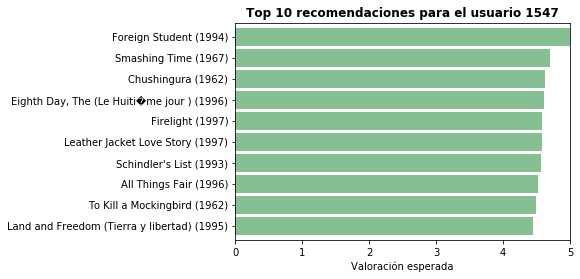

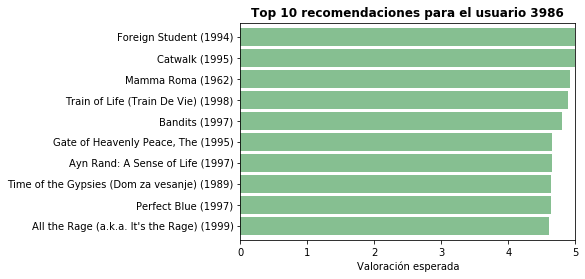

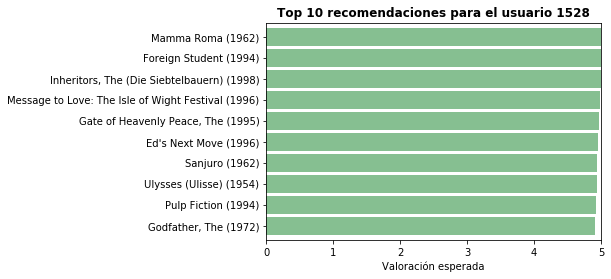

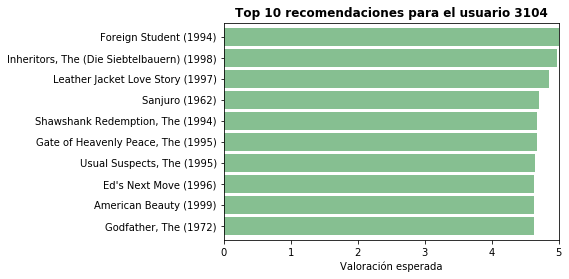

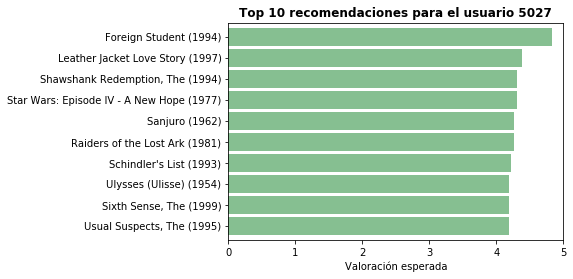

In [23]:
users_to_plot = np.random.randint(low = 0, high = n_users, size = 5)

for i in range(len(users_to_plot)):
    recomendar_para_usuario(int(users_to_plot[i]))